In [1]:
!pip install -q kaggle

In [2]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
 !chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c dogs-vs-cats

sampleSubmission.csv: Skipping, found more recently modified local copy (use --force to force download)
test1.zip: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!unzip /content/train.zip
print('done')

Archive:  /content/train.zip
replace train/cat.0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: NA
done


In [7]:
%mkdir images

mkdir: cannot create directory ‘images’: File exists


In [8]:
%mv train images

In [37]:
class CatDogDataset(torch.utils.data.Dataset):                             #data generating class
    def __init__(self, file_list, dir, mode='train', transform = None):
        self.file_list = file_list
        self.dir = dir
        self.mode= mode
        self.transform = transform
        if self.mode == 'train':
            if 'dog' in self.file_list[0]:
                self.label = 1
            else:
                self.label = 0
            
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.dir, self.file_list[idx]))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            img = img.numpy()
            return img.astype('float32'), self.label
        else:
            img = img.numpy()
            return img.astype('float32'), self.file_list[idx]

transform1 = transform.Compose([
    transform.RandomResizedCrop(224),  
    transform.ToTensor(),
    transform.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

In [38]:
train_dir = 'images/train'
cat_files = []
dog_files = []

cat_files= [i for i in os.listdir('images/train') if 'cat' in i]
dog_files = [i for i in os.listdir('images/train') if 'dog' in i]

cats = CatDogDataset(cat_files, train_dir, transform = transform1)
dogs = CatDogDataset(dog_files, train_dir, transform = transform1)


In [39]:
catdogs = torch.utils.data.ConcatDataset([cats,dogs])

In [40]:
catdogs
dataloader = torch.utils.data.DataLoader(catdogs, batch_size = 32, shuffle=True)

In [41]:
images, labels = iter(dataloader).next()

In [56]:
classes = {}
classes[1] = 'dog'
classes[0] = 'cat'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dog
torch.Size([3, 224, 224])


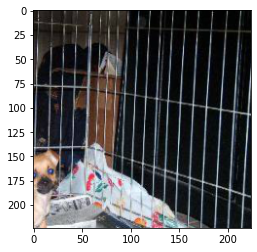

In [83]:
npimg = images[4].numpy()
npimg = np.transpose(npimg,(1,2,0))

std_corr = np.asarray([0.229, 0.224, 0.225])
mean = np.asarray([0.485, 0.456, 0.406])

npimg = np.multiply(npimg,std_corr) + mean
plt.imshow(npimg)
print(classes[labels[4].item()])
print(images[1].shape)

Importing libraries

In [36]:
import os
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transform
import torchvision.datasets as datasets

import warnings
warnings.filterwarnings('ignore')
from PIL import Image

In [71]:
def imshow(images,title):
  npimg = images.numpy()
  
  std_corr = np.asarray((0.229, 0.224, 0.225)).reshape(3,1,1)
  mean = np.asarray((0.485, 0.456, 0.406)).reshape(3,1,1)
  
  npimg = np.multiply(npimg , std_corr) + mean
  npimg = np.transpose(npimg, (1,2,0))

  plt.figure(figsize=(batchsize*4,4))
  plt.imshow(npimg)
  plt.title(title)
  plt.show()

In [179]:
batchsize=4
def show_batch():
  dataloader = torch.utils.data.DataLoader(catdogs,batch_size=batchsize,shuffle=True)
  dataiter = iter(dataloader)
  
  images,labels = next(dataiter)

  output = model.forward(images)
  a, pred = torch.max(output.data,1)
  print(a)
  imshow(torchvision.utils.make_grid(images),[classes[x.item()] for x in pred])


In [257]:
rest = torchvision.models.alexnet(pretrained=True)

In [258]:
rest

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [261]:
in_features = rest.classifier[6].in_features
rest.classifier  = nn.Sequential(
    nn.Dropout(p=0.5,inplace=False),
    nn.Linear(in_features=9216, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=4096, out_features=2, bias=True),
    nn.Softmax(dim=1)
)



In [262]:
rest

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [263]:
for params in rest.parameters():
  if params.requires_grad:
    print(params.shape)

torch.Size([64, 3, 11, 11])
torch.Size([64])
torch.Size([192, 64, 5, 5])
torch.Size([192])
torch.Size([384, 192, 3, 3])
torch.Size([384])
torch.Size([256, 384, 3, 3])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([4096, 9216])
torch.Size([4096])
torch.Size([4096, 4096])
torch.Size([4096])
torch.Size([2, 4096])
torch.Size([2])


In [264]:
batch_size = 1
def evaluation(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        outputs = nn.functional.softmax(outputs, dim=1)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total


In [265]:
import copy
device = torch.device('cuda:0')
loss_epc=[]
def fit(model,trainloader,opt,loss_fn,epochs):
  
  min_loss = 1000
  for j in tqdm_notebook(range(epochs),total=epochs ,unit= 'epoch'): 
    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = model.forward(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
      
        
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
        if i%200 == 0:
          print('For epoch [{}/{}]: Training error after {} iterations is {}'.format(j,epochs,i,loss.item()))
          
          if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(vgg.state_dict())
            print('Min loss %0.2f' % min_loss)

    print('Loss after {} epochs is {}'.format(j,loss.item()))    
    loss_epc.append(loss.item())
        
    print('The training accuracy is, {}'.format(evaluation(trainloader,model)))
  
  plt.plot(loss_epc,'red')
  plt.xlabel('epochs')
  plt.ylabel('error')

In [266]:
rest = rest.to(device)
loss_fn  = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(rest.parameters(),lr=0.001)

For epoch [0/10]: Training error after 0 iterations is 0.6996397376060486
Min loss 0.70
For epoch [0/10]: Training error after 200 iterations is 0.5643513202667236
Min loss 0.56
For epoch [0/10]: Training error after 400 iterations is 0.4845259189605713
Min loss 0.48
For epoch [0/10]: Training error after 600 iterations is 0.4219347834587097
Min loss 0.42
Loss after 0 epochs is 0.40862390398979187
The training accuracy is, 87.508
For epoch [1/10]: Training error after 0 iterations is 0.4497230350971222
For epoch [1/10]: Training error after 200 iterations is 0.38065439462661743
Min loss 0.38
For epoch [1/10]: Training error after 400 iterations is 0.39391574263572693
For epoch [1/10]: Training error after 600 iterations is 0.37802988290786743
Min loss 0.38
Loss after 1 epochs is 0.35373881459236145
The training accuracy is, 89.084
For epoch [2/10]: Training error after 0 iterations is 0.4066348969936371
For epoch [2/10]: Training error after 200 iterations is 0.4375087022781372
For epo

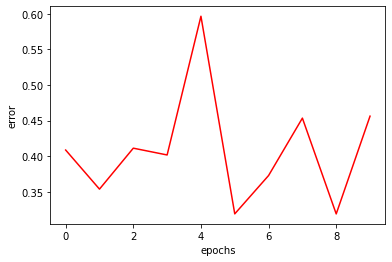

In [267]:
from tqdm.notebook import tqdm_notebook 
fit(rest,dataloader,optimizer,loss_fn,10)

In [268]:
!unzip /content/test1.zip

Streaming output truncated to the last 5000 lines.
  inflating: test1/5499.jpg          
  inflating: test1/55.jpg            
  inflating: test1/550.jpg           
  inflating: test1/5500.jpg          
  inflating: test1/5501.jpg          
  inflating: test1/5502.jpg          
  inflating: test1/5503.jpg          
  inflating: test1/5504.jpg          
  inflating: test1/5505.jpg          
  inflating: test1/5506.jpg          
  inflating: test1/5507.jpg          
  inflating: test1/5508.jpg          
  inflating: test1/5509.jpg          
  inflating: test1/551.jpg           
  inflating: test1/5510.jpg          
  inflating: test1/5511.jpg          
  inflating: test1/5512.jpg          
  inflating: test1/5513.jpg          
  inflating: test1/5514.jpg          
  inflating: test1/5515.jpg          
  inflating: test1/5516.jpg          
  inflating: test1/5517.jpg          
  inflating: test1/5518.jpg          
  inflating: test1/5519.jpg          
  inflating: test1/552.jpg           

In [269]:
%mkdir images_test
%mv test1 images_test

In [270]:
filename_pth = 'ckpt_densenet121_catdog.pth'
torch.save(rest.state_dict(), filename_pth)

In [274]:
test_dir = 'images_test/test1'
test_files = os.listdir(test_dir)
test_transform = transform.Compose([
    transform.RandomResizedCrop(224),
    transform.ToTensor()
])

In [286]:
testset = CatDogDataset(test_files,test_dir,mode ='test',transform=test_transform)

In [287]:
test_loader = torch.utils.data.DataLoader(testset,batch_size=32,shuffle=False)

In [289]:
rest.eval()
fn_list,pred_list = [], []
for x,fn in test_loader:
  with torch.no_grad():
    x = x.to(device)
    out = rest.forward(x)
    pred = torch.argmax(out.data,1)
    fn_list += [n[:-4] for n in fn]
    pred_list += [p.item() for p in pred]

In [295]:
import pandas as pd
submission = pd.DataFrame({'id':fn_list,'label':pred_list})


In [301]:
submission.to_csv('submission.csv',index=False)

In [ ]:
/cat
